# imports

In [109]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import nltk, re, string
import sys, os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer


# Part 1

**Question 1**

i) \
\
Currently the regex might remove to many special characters.

The regex used was:
text = re.sub(r'[^\w\s]', '', text)  

which effectively removes anything that is not a word or a white space.
The removal of punctuation by the above regex may be too much.

For example, in the dataset the line "john deere, john 3:16	2016" exists. With the regex applied, it would instead read
"john deere, john 316   2016". With the colon removed, the clear religious context of "john 3:16" is now "john 316" which has ambiguous meaning.

To fix this mistake, the regex can be modified to include punctuation, as demonstrated in the cell below.

In [15]:
# include punctuation in regex pattern
text = "hello你好 !!123🗿 🤫🧏‍♂️ John 3:16"

import string
pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation
text = re.sub(pattern, '', text)  
print(text)

hello你好 !!123  John 3:16


ii) \
\
K-Fold cross validation can be used instead of only one training-test split.

K-Fold CV divides the subset into *k subsets. Then, *k-1 subsets are used for training and the remaining subset is used for validation. In this method, the training is iterated *k times, with a different subset used for validation each time.

Stratified K-Fold is an additional type of K-Fold CV that ensures each "fold" of the dataset has the same proportion of observations with a given label. This helps in creating better class distribution accross folds.

Below is a code snippet that demonstrates the use of Stratified K-Fold CV in this assignment.

In [ ]:
### non-working code. for demonstration only!! ###
pipeline = make_pipeline(
    TfidfVectorizer(),
    BernoulliNB()    
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bnb_scores = cross_val_score(
    pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=cv,
    scoring='accuracy'
)

**Question 2**

Data import and Pre-processing steps.

Best pre-processing steps:
- Lowercasing
- removal of special characters except punctuation
- tokenizing words
- filtering stop words
- lemmatizing words instead of stemming

In [78]:
#all common setup code.

df = pd.read_csv('dataset.tsv', sep='\t')
df = df.drop_duplicates()
df = df.dropna()

# concantenante

df['content'] = df['artist_name'].astype(str) + " " + df['track_name'].astype(str) + " "  + df['release_date'].astype(str) + " " + df['genre'] + " " + df['lyrics']

# pre-processing

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

df['content'] = df['content'].apply(preprocess_text)

    


[nltk_data] Downloading package stopwords to /home/raymo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raymo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/raymo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raymo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Multinomial Naive Bayes method

In [74]:
mnb_pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()    
)

mnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mnb_scoring = {
    'accuracy'        : 'balanced_accuracy',  # you can still use the built-in string
    'precision_macro' : make_scorer(
        precision_score,
        average='macro',
        zero_division=0      # or 1, or 'warn'—your choice
    ),
    'recall_macro'   : make_scorer(
        recall_score,
        average='macro',
        zero_division=0      # ensures recall handles any 0/0 in its internal precision/recall
    ),
    'f1_macro'        : make_scorer(
        f1_score,
        average='macro',
        zero_division=0      # ensures F1 handles any 0/0 in its internal precision/recall
    )
}

mnb_results = cross_validate(
    mnb_pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=mnb_cv,
    scoring=mnb_scoring,
    return_train_score=False
)

for metric in mnb_scoring:
    key = f"test_{metric}"
    mnb_scores = mnb_results[key]
    # print(f"Per-fold {key}:", mnb_scores)
    print(f"Mean {key}      :", np.mean(mnb_scores))

Mean test_accuracy      : 0.4681716126546564
Mean test_precision_macro      : 0.5266436296870303
Mean test_recall_macro      : 0.4681716126546564
Mean test_f1_macro      : 0.43816909491649403


**Question 3)**

Bernoulli Naive Bayes method

In [79]:
bnb_pipeline = make_pipeline(
    TfidfVectorizer(),
    BernoulliNB()    
)

bnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bnb_scoring = {
    'accuracy'        : 'balanced_accuracy',  # you can still use the built-in string
    'precision_macro' : make_scorer(
        precision_score,
        average='macro',
        zero_division=0      # or 1, or 'warn'—your choice
    ),
    'recall_macro'   : make_scorer(
        recall_score,
        average='macro',
        zero_division=0      # ensures recall handles any 0/0 in its internal precision/recall
    ),
    'f1_macro'        : make_scorer(
        f1_score,
        average='macro',
        zero_division=0      # ensures F1 handles any 0/0 in its internal precision/recall
    )
}

bnb_results = cross_validate(
    bnb_pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=bnb_cv,
    scoring=bnb_scoring,
    return_train_score=False
)

for metric in bnb_scoring:
    key = f"test_{metric}"
    bnb_scores = bnb_results[key]
    # print(f"Per-fold {key}:", bnb_scores)
    print(f"Mean {key}      :", np.mean(bnb_scores))

Mean test_accuracy      : 0.38589700680882916
Mean test_precision_macro      : 0.3564937760863204
Mean test_recall_macro      : 0.38589700680882916
Mean test_f1_macro      : 0.3377857649686252


In [43]:
#assessing the balance of the dataset.
counts = df['topic'].value_counts()
print(counts)

topic
dark         487
sadness      371
personal     341
lifestyle    202
emotion       79
Name: count, dtype: int64




- Appropriate metrics: Precision, Recall, F1, Accuracy

    1.Precision: TP/TP + FP.
Precision is good for assessing how "clean" the prediction classes are. However, it ignores "misses" or false negatives. 

    2. Recall: TP/TP + FN.
Recall shows the coverage of the recovery. However, recall ignores false positives.

    3. F1: Harmonic mean of Precision and Recall.
Trade-off between recall and precision.

    4. Accuracy: Overall fraction of correctly labelled documents (TP + TN / dataset). Accounts for all types of classifications (FP, FN) however it can be misleading if some classess dominate.


- The balance of the class is assessed.
As the balance is slightly off (dark has 487 whilst emotion has 79), a possible solutions is to instead use a macro-average of the metrics to account for multiple-classes. This approach gives higher than normal influence to dominated (smaller) classes. Smaller classes are still important as a lower number of songs does not neccessarily mean that topic has a lower number of users.
- Therefore, balanced_accuracy, and macro-f1, macro-recall, macro-precision was used as the main metrics.


- An overall comparison of BNB and MNB found that MNB was superior.

**Question 4)**

Gridsearch through top N words.

In [ ]:
#gridsearch through bnb.
feature_limits = [1, 5, 10, 100, 325, 350, 375, 500, 1000, 10000]
bnb_results_df = pd.DataFrame({
    'Feature Limit': feature_limits,
    'accuracy': [0.0 for _ in feature_limits],
    'precision_macro': [0.0 for _ in feature_limits],
    'recall_macro': [0.0 for _ in feature_limits],
    'f1_macro': [0.0 for _ in feature_limits],
})
for limit in feature_limits:
    bnb_pipeline = make_pipeline(
        TfidfVectorizer(max_features=limit),
        BernoulliNB()
    )
    bnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bnb_results = cross_validate(
        bnb_pipeline,
        df['content'],       # input features
        df['topic'],         # labels
        cv=bnb_cv,
        scoring=bnb_scoring,
        return_train_score=False
    )
    print(f"Max features: {limit}")
    for metric in bnb_scoring:
        key = f"test_{metric}"
        bnb_scores = bnb_results[key]
        bnb_results_df.loc[bnb_results_df['Feature Limit'] == limit, metric] = np.mean(bnb_scores)
        print(f"Mean {key}      :", np.mean(bnb_scores))
# Plotting the results

Max features: 1
Mean test_accuracy      : 0.20704012676678363
Mean test_precision_macro      : 0.09013977107843703
Mean test_recall_macro      : 0.20704012676678363
Mean test_f1_macro      : 0.12334710877888015
Max features: 5
Mean test_accuracy      : 0.22608019262946435
Mean test_precision_macro      : 0.1850648039372525
Mean test_recall_macro      : 0.22608019262946435
Mean test_f1_macro      : 0.18271164668726775
Max features: 10
Mean test_accuracy      : 0.3233548639584972
Mean test_precision_macro      : 0.2786631498916904
Mean test_recall_macro      : 0.3233548639584972
Mean test_f1_macro      : 0.2950774039799785
Max features: 100
Mean test_accuracy      : 0.48540509062709347
Mean test_precision_macro      : 0.5184512500633984
Mean test_recall_macro      : 0.48540509062709347
Mean test_f1_macro      : 0.49469659041637815
Max features: 325
Mean test_accuracy      : 0.5543962765667467
Mean test_precision_macro      : 0.5648899854887901
Mean test_recall_macro      : 0.554396276566

In [ ]:
#gridsearch through mnb
feature_limits = [1, 5, 10, 100, 325, 350, 375, 500, 1000, 10000]
mnb_results_df = pd.DataFrame({
    'Feature Limit': feature_limits,
    'accuracy': [0.0 for _ in feature_limits],
    'precision_macro': [0.0 for _ in feature_limits],
    'recall_macro': [0.0 for _ in feature_limits],
    'f1_macro': [0.0 for _ in feature_limits],
})
for limit in feature_limits:
    mnb_pipeline = make_pipeline(
        TfidfVectorizer(max_features=limit),
        MultinomialNB()
    )
    mnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mnb_results = cross_validate(
        mnb_pipeline,
        df['content'],       # input features
        df['topic'],         # labels
        cv=mnb_cv,
        scoring=mnb_scoring,
        return_train_score=False
    )
    print(f"Max features: {limit}")
    for metric in mnb_scoring:
        key = f"test_{metric}"
        mnb_scores = mnb_results[key]
        mnb_results_df.loc[mnb_results_df['Feature Limit'] == limit, metric] = np.mean(mnb_scores)
        print(f"Mean {key}      :", np.mean(mnb_scores))

Max features: 1
Mean test_accuracy      : 0.2
Mean test_precision_macro      : 0.0658108108108108
Mean test_recall_macro      : 0.2
Mean test_f1_macro      : 0.09903359553609485
Max features: 5
Mean test_accuracy      : 0.20530084377991448
Mean test_precision_macro      : 0.1198839692844009
Mean test_recall_macro      : 0.20530084377991448
Mean test_f1_macro      : 0.1245516487633777
Max features: 10
Mean test_accuracy      : 0.32695133613437066
Mean test_precision_macro      : 0.33986213047802016
Mean test_recall_macro      : 0.32695133613437066
Mean test_f1_macro      : 0.3053865395230919
Max features: 100
Mean test_accuracy      : 0.5663622093901199
Mean test_precision_macro      : 0.7291975839318667
Mean test_recall_macro      : 0.5663622093901199
Mean test_f1_macro      : 0.5810927485912056
Max features: 325
Mean test_accuracy      : 0.6470343063655845
Mean test_precision_macro      : 0.7488141390733798
Mean test_recall_macro      : 0.6470343063655845
Mean test_f1_macro      : 0.6

MultinomialNB Gridsearch Raw Results:
   Feature Limit  accuracy  precision_macro  recall_macro  f1_macro
0              1  0.200000         0.065811      0.200000  0.099034
1              5  0.205301         0.119884      0.205301  0.124552
2             10  0.326951         0.339862      0.326951  0.305387
3            100  0.566362         0.729198      0.566362  0.581093
4            325  0.647034         0.748814      0.647034  0.652202
5            350  0.647100         0.710999      0.647100  0.648029
6            375  0.645418         0.712142      0.645418  0.646314
7            500  0.635973         0.671193      0.635973  0.634571
8           1000  0.584836         0.653711      0.584836  0.578532
9          10000  0.468172         0.526644      0.468172  0.438169


BernoulliNB Gridsearch Raw Results:
   Feature Limit  accuracy  precision_macro  recall_macro  f1_macro
0              1  0.207040         0.090140      0.207040  0.123347
1              5  0.226080         0.185

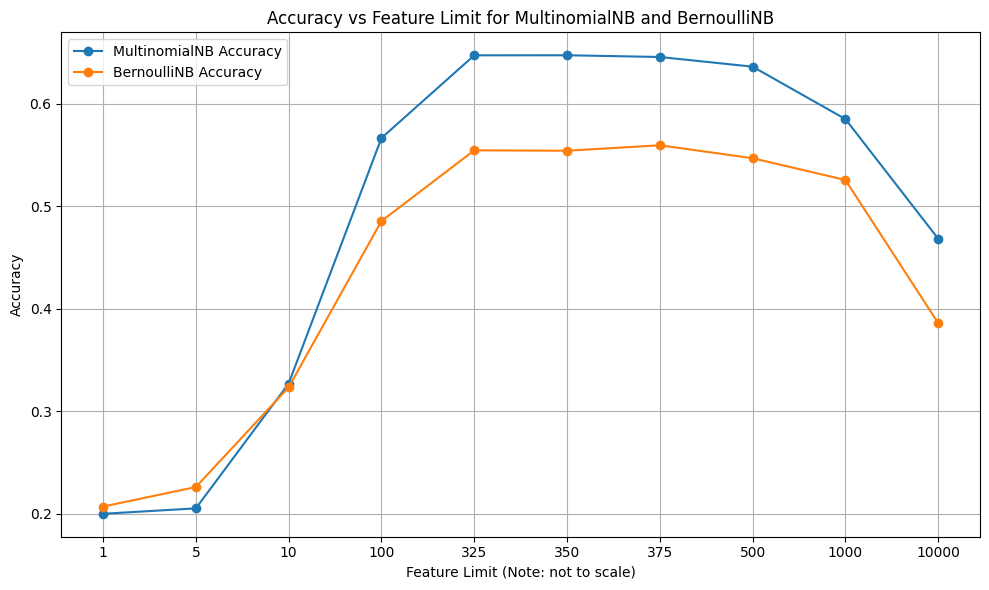

In [ ]:
print("MultinomialNB Gridsearch Raw Results:")
print(mnb_results_df)
print("\n")
print("BernoulliNB Gridsearch Raw Results:")
print(bnb_results_df)
# plotting feature limits against accuracy
plt.figure(figsize=(10, 6))
plt.plot(mnb_results_df['Feature Limit'].astype(str), mnb_results_df['accuracy'], marker='o', label='MultinomialNB Accuracy')
plt.plot(bnb_results_df['Feature Limit'].astype(str), bnb_results_df['accuracy'], marker='o', label='BernoulliNB Accuracy')
plt.xlabel('Feature Limit (Note: not to scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Feature Limit for MultinomialNB and BernoulliNB')
plt.legend()
plt.grid()
plt.tight_layout()

Through a gridsearch, it was found that each model performed best at about N=~350. The performance was vastly superior to N=inf (which is the default setting.)

N=350 is used as the feature number.

**Question 5)**

Other machine learning method (Support Vector machine SVM selected)

SVMs separate classes by forming a decision boundary (hyperplane) in the feature space that seeks to maximise the margin between two classifications.

A margin is the distance between the decision boundary and the closest data-points in each class. The data-points closest to the decision boundary are also known as the "support vectors". These closest-datapoints then define the boundary between two classes.

SVMs are suitable for classification over vectorized words. Vectorized words are typically sparse and high-dimensional. SVMs are good for this task because they only focus on a few key points which is much more computationally efficient that other methods that account for all datapoints, such as K-NNs. Flexible kernels that support sparse feature spaces additionally help to ensure good performance. Additionally, optimizations in embedding methods such as TF-IDF means that semantically similar words end up closer to each other compared to dissimilar words. This feature common to many word-vectorization method naturally forms clusters between similar words and spatial relationships (e.g. king - queen ~= man - woman) which lends themselves to natural and effective decision boundaries that can be identified by a SVM.

A SVM is primarily tunable through three parameters. The type of decision boundary / kernel (linear, polynomial etc), C: the penalty term for misclassifying points, and γ: which influences the flexibility of the decision boundary. A basic gridsearch will be performed over these parameters to find the best ones.

Due to the reasons presented above, it is hypothesised that the SVM would be much better than the MNB and BNB. This is because the SVM utilises and real-valued feature weights extracted by vectorization, as well as optimizations involved in TF-IDF vectorization. Conversely, the MNB and BNB instead relies on probabilistic calculations related to binary presence/absence or raw word counts. This approach by the MNB and BNB means that it is simply using much less information to make it's decisions, failing to leverage the rich features extracted by optimised vectorization methods such as TF-IDF.

In [ ]:
# performing gridsearch on SVM

svm_pipeline = make_pipeline(
    TfidfVectorizer(max_features=400),
    SVC()    
)

svm_param_grid = [
    # For linear kernel we only need C
    {
        'svc__kernel': ['linear'],
        'svc__C':      [0.1, 1, 10, 100]
    },
    # For RBF, poly, sigmoid we also tune gamma
    {
        'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__C':      [0.1, 1, 10, 100],
        'svc__gamma':  ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
]

svm_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=svm_cv,
    scoring='accuracy',
    n_jobs=-1,            # parallelize across cores if you like
    verbose=1
)

svm_grid.fit(df['content'], df['topic'])

print("Best params :", svm_grid.best_params_)
print("Best score  :", svm_grid.best_score_)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best params : {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best score  : 0.8824324324324324


In [ ]:
# single-run version of the pipeline (faster)

pipeline = make_pipeline(
    TfidfVectorizer(max_features=400),
    SVC(kernel='rbf', C=10, gamma='scale')  # using best params from grid search
)
pipeline.fit(df['content'], df['topic'])
svm_scoring = mnb_scoring  # reusing the same scoring metrics
svm_results = cross_validate(
    pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=svm_cv,
    scoring=svm_scoring,
    return_train_score=False
)
for metric in svm_scoring:
    key = f"test_{metric}"
    svm_scores = svm_results[key]
    print(f"Mean {key}      :", np.mean(svm_scores))




Mean test_accuracy      : 0.8623461566450563
Mean test_precision_macro      : 0.8842018077262555
Mean test_recall_macro      : 0.8623461566450563
Mean test_f1_macro      : 0.8716593958235423


My hypothesis regarding SVMs was correct, in that it was very effective in classifying words. MNB and BNB accuracy peaked at around 0.647 and 0.559 respectively, whilst SVM was able to achieve a significantly higher accuracy of 0.862. Other metrics yielded similar results.

Therefore, the "best" method was the SVM, with settings " kernel='rbf', C=10, gamma='scale' "